<a href="https://colab.research.google.com/github/LatifulJoy/covid19-cnn-TL-mobilenet/blob/main/covid_19_ensemble_learning_with_augmentation(21_10_22).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
import os 
import pathlib 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
import random
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Conv2D, MaxPool2D,SeparableConv2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from google.colab import files
from sklearn.metrics import classification_report,confusion_matrix

# Uploading The Dataset

In [2]:
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"latifuljoy","key":"c9493e600d8dfc76ec7a58ea29031a33"}'}

In [3]:
import os
os.environ["KAGGLE_CONFIG_DIR"] = "/content"

In [4]:
!kaggle datasets download -d latifuljoy/covid-chest-xray-image-dataset

 99% 481M/484M [00:14<00:00, 32.0MB/s]
100% 484M/484M [00:14<00:00, 35.6MB/s]


In [5]:
!unzip \*.zip

Archive:  covid-chest-xray-image-dataset.zip
  inflating: COVID_IEEE/covid/01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg  
  inflating: COVID_IEEE/covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C.jpeg  
  inflating: COVID_IEEE/covid/1-s2.0-S0140673620303706-fx1_lrg.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-a.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-b.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-c.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S0929664620300449-gr2_lrg-d.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-001.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300608-main.pdf-002.jpg  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-002-a2.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b1.png  
  inflating: COVID_IEEE/covid/1-s2.0-S1684118220300682-main.pdf-003-b2.png 

# Augmentation

In [8]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import Augmentor

In [12]:
P = Augmentor.Pipeline('/content/COVID_IEEE', output_directory='/content/COVID_IEEE')

Initialised with 1493 image(s) found.
Output directory set to /content/COVID_IEEE.

In [13]:
P.rotate(probability=0.7, max_left_rotation =10, max_right_rotation=10)

In [14]:
P.zoom(probability  = 0.3, min_factor = 1.1, max_factor = 1.6)

In [15]:
P.sample(2000)

Processing <PIL.Image.Image image mode=L size=1873x1478 at 0x7F5F485A59D0>: 100%|██████████| 2000/2000 [03:32<00:00,  9.40 Samples/s]


# Dataset Preprocessing

In [16]:
for dirpath,dirnames,filenames in os.walk("/content/COVID_IEEE"):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

there are 3 directories and 0 images in '/content/COVID_IEEE'.
there are 0 directories and 1237 images in '/content/COVID_IEEE/normal'.
there are 0 directories and 1109 images in '/content/COVID_IEEE/covid'.
there are 0 directories and 1262 images in '/content/COVID_IEEE/virus'.


In [17]:
import pathlib
import tensorflow as tf
data_dir = pathlib.Path("/content/COVID_IEEE")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")]))
class_names

array(['covid', 'normal', 'virus'], dtype='<U6')

In [18]:
img_height =224
img_width =224

In [19]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'training',
    seed =123,
    image_size = (img_height, img_width),
    batch_size =32
)

Found 3493 files belonging to 3 classes.
Using 2795 files for training.


In [20]:
validation_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset = 'validation',
    seed =123,
    image_size = (img_height, img_width),
    batch_size = 32
)

Found 3493 files belonging to 3 classes.
Using 698 files for validation.


# Normalization

In [53]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [54]:
import numpy as np
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, label_batch= next(iter(normalized_ds))
first_image = image_batch[0]
#Notice the pixel values are now in (0,1)
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [55]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_ds= validation_ds.cache().prefetch(buffer_size = AUTOTUNE)

#  Visualizing The Image

In [93]:
def view_image(target_dir, target_class):
    target_folder = target_dir+target_class
    random_image = random.sample(os.listdir(target_folder),1)
    print(random_image)
    img = mpimg.imread(target_folder+"/"+ random_image[0])
    plt.imshow(img, cmap ="gray")
    plt.title(target_class)
    plt.axis("off")
    print(f"image shape {img.shape}")
    
    return img

['person942_virus_1611.jpeg']
image shape (1120, 1592)


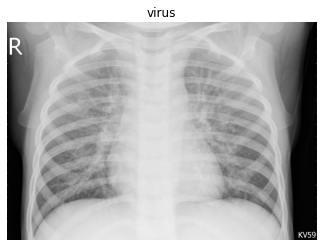

In [95]:
img = view_image("/content/COVID_IEEE/","virus")

['IM-0433-0001.jpeg']
image shape (1677, 1916)


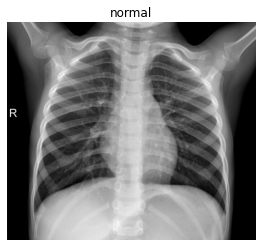

In [102]:
img = view_image("/content/COVID_IEEE/","normal")

['AR-1.jpg']
image shape (401, 443, 3)


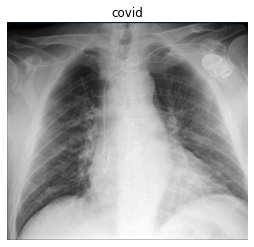

In [113]:
img = view_image("/content/COVID_IEEE/","covid")

# Developed CNN model

In [61]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [62]:
model = Sequential()

#Block Number 1
model.add(Conv2D(input_shape = (224,224,3), filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=32,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(MaxPool2D((2,2)))


#Block Number 2
model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))


model.add(Conv2D(filters=64,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))
model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 3
model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=128,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))
Dropout(0.20)

#Block Number 4
model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(filters=256,padding="same", kernel_size= (3,3)))
model.add(Activation("relu"))

model.add(MaxPool2D((2,2)))

model.add(MaxPool2D((2,2)))

Dropout(0.40)


# Fully Connected layer
model.add(Flatten())

model.add(Dense(units=1024, activation="relu"))

model.add(Dense(units= 256, activation="relu"))
model.add(Dense(units=128, activation="relu"))
Dropout(0.40)

model.add(Dense(units=3, activation="softmax"))

In [63]:
model.compile(optimizer = opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [64]:
history1 = model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
88/88 [==============================] - 11s 121ms/step - loss: 0.7549 - accuracy: 0.6798 - val_loss: 0.4516 - val_accuracy: 0.8209
Epoch 2/20
88/88 [==============================] - 11s 120ms/step - loss: 0.3927 - accuracy: 0.8411 - val_loss: 0.3377 - val_accuracy: 0.8639
Epoch 3/20
88/88 [==============================] - 11s 122ms/step - loss: 0.3218 - accuracy: 0.8762 - val_loss: 0.2902 - val_accuracy: 0.8840
Epoch 4/20
88/88 [==============================] - 11s 122ms/step - loss: 0.2269 - accuracy: 0.9123 - val_loss: 0.2374 - val_accuracy: 0.8997
Epoch 5/20
88/88 [==============================] - 11s 121ms/step - loss: 0.2022 - accuracy: 0.9263 - val_loss: 0.2153 - val_accuracy: 0.9226
Epoch 6/20
88/88 [==============================] - 11s 121ms/step - loss: 0.1980 - accuracy: 0.9213 - val_loss: 0.1873 - val_accuracy: 0.9355
Epoch 7/20
88/88 [==============================] - 11s 120ms/step - loss: 0.1518 - accuracy: 0.9445 - val_loss: 0.1884 - val_accuracy: 0.9284

Text(0.5, 1.0, 'Accuracy Curves')

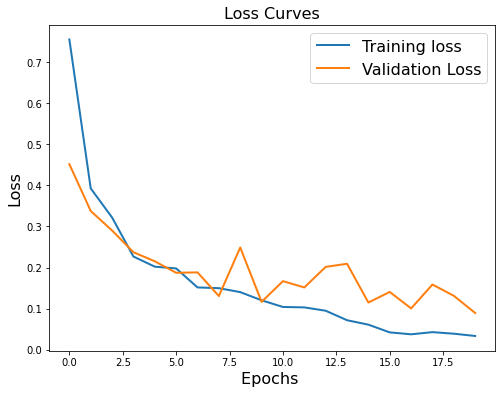

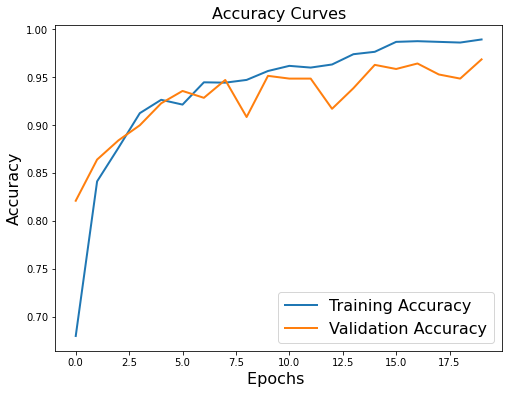

In [65]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['loss'],linewidth=2.0)
plt.plot(history1.history['val_loss'],linewidth=2.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history1.history['accuracy'],linewidth=2.0)
plt.plot(history1.history['val_accuracy'],linewidth=2.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

# Mounting The Drive with colab

In [84]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [85]:
model.save("/content/drive/MyDrive/model.hdf5")

# Transfer Learning Model Inception V3

In [66]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [67]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = InceptionV3(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model1 = Model(inputs = base_model.inputs, outputs = predictions)

87910968/87910968 [==============================] - 0s 0us/step


In [68]:
model1.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [69]:
history2 = model1.fit(
    train_ds,
    validation_data = validation_ds,
    epochs=20
)

Epoch 1/20
88/88 [==============================] - 33s 274ms/step - loss: 0.3613 - accuracy: 0.8605 - val_loss: 0.9184 - val_accuracy: 0.6275
Epoch 2/20
88/88 [==============================] - 20s 231ms/step - loss: 0.0771 - accuracy: 0.9757 - val_loss: 0.2060 - val_accuracy: 0.9370
Epoch 3/20
88/88 [==============================] - 20s 233ms/step - loss: 0.0211 - accuracy: 0.9953 - val_loss: 0.1329 - val_accuracy: 0.9556
Epoch 4/20
88/88 [==============================] - 20s 228ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.1590 - val_accuracy: 0.9542
Epoch 5/20
88/88 [==============================] - 20s 228ms/step - loss: 0.0361 - accuracy: 0.9875 - val_loss: 0.1649 - val_accuracy: 0.9542
Epoch 6/20
88/88 [==============================] - 20s 229ms/step - loss: 0.0704 - accuracy: 0.9771 - val_loss: 0.2430 - val_accuracy: 0.9499
Epoch 7/20
88/88 [==============================] - 20s 230ms/step - loss: 0.0511 - accuracy: 0.9821 - val_loss: 0.1824 - val_accuracy: 0.9513

In [86]:
model1.save("/content/drive/MyDrive/model1.hdf5")

# DenseNet 121

In [70]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [71]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = DenseNet121(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model2 = Model(inputs = base_model.inputs, outputs = predictions)

29084464/29084464 [==============================] - 1s 0us/step


In [72]:
model2.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [73]:
history3 = model2.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
88/88 [==============================] - 51s 433ms/step - loss: 0.2880 - accuracy: 0.8880 - val_loss: 0.2731 - val_accuracy: 0.9011
Epoch 2/20
88/88 [==============================] - 31s 356ms/step - loss: 0.0515 - accuracy: 0.9843 - val_loss: 0.0527 - val_accuracy: 0.9814
Epoch 3/20
88/88 [==============================] - 31s 352ms/step - loss: 0.0109 - accuracy: 0.9979 - val_loss: 0.0261 - val_accuracy: 0.9957
Epoch 4/20
88/88 [==============================] - 31s 354ms/step - loss: 0.0044 - accuracy: 0.9989 - val_loss: 0.0313 - val_accuracy: 0.9900
Epoch 5/20
88/88 [==============================] - 31s 353ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0294 - val_accuracy: 0.9914
Epoch 6/20
88/88 [==============================] - 31s 353ms/step - loss: 0.0027 - accuracy: 0.9996 - val_loss: 0.0249 - val_accuracy: 0.9928
Epoch 7/20
88/88 [==============================] - 31s 354ms/step - loss: 0.0028 - accuracy: 0.9993 - val_loss: 0.0257 - val_accuracy: 0.9928

In [87]:
model2.save("/content/drive/MyDrive/model2.hdf5")

# MobileNet

In [80]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [81]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D,  GlobalAveragePooling2D
base_model = MobileNet(
    input_shape=(224,224,3),
    weights="imagenet",
    include_top = False)

#Freeze the first ten layers
for layer in base_model.layers[:10]:
  layer.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x= Dense(512, activation = 'relu')(x)
x= Dropout(0.4)(x)
predictions  = Dense(3, activation = 'softmax')(x)
model3 = Model(inputs = base_model.inputs, outputs = predictions)

In [82]:
model3.compile(optimizer =opt, loss = tf.losses.SparseCategoricalCrossentropy(from_logits = False),metrics=['accuracy'])

In [83]:
history4 = model3.fit(
    train_ds,
    validation_data = validation_ds,
    epochs= 20
)

Epoch 1/20
88/88 [==============================] - 17s 139ms/step - loss: 0.3792 - accuracy: 0.8501 - val_loss: 4.1454 - val_accuracy: 0.3352
Epoch 2/20
88/88 [==============================] - 12s 131ms/step - loss: 0.0708 - accuracy: 0.9778 - val_loss: 2.5483 - val_accuracy: 0.6175
Epoch 3/20
88/88 [==============================] - 12s 132ms/step - loss: 0.0204 - accuracy: 0.9968 - val_loss: 1.2523 - val_accuracy: 0.6834
Epoch 4/20
88/88 [==============================] - 12s 135ms/step - loss: 0.0070 - accuracy: 1.0000 - val_loss: 0.2815 - val_accuracy: 0.9083
Epoch 5/20
88/88 [==============================] - 12s 133ms/step - loss: 0.0029 - accuracy: 1.0000 - val_loss: 0.1420 - val_accuracy: 0.9499
Epoch 6/20
88/88 [==============================] - 12s 132ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.1281 - val_accuracy: 0.9613
Epoch 7/20
88/88 [==============================] - 11s 131ms/step - loss: 0.0013 - accuracy: 1.0000 - val_loss: 0.1296 - val_accuracy: 0.9628

In [88]:
model3.save("/content/drive/MyDrive/model3.hdf5")

# Ensemble Learning Model 1 (Developed CNN+ Inception V3 + DenseNet121)

In [89]:
import tensorflow as tf
opt=tf.keras.optimizers.Adam(learning_rate=0.0001)

In [90]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model("/content/drive/MyDrive/model.hdf5")
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model('/content/drive/MyDrive/model1.hdf5')
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')

model_3 = load_model('/content/drive/MyDrive/model2.hdf5')
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1, model_2, model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

In [91]:
ensemble_model.compile(optimizer = opt, 
                       loss= tf.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics = ['accuracy'])

In [92]:
ensemble_history = ensemble_model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs =15
)

Epoch 1/15
88/88 [==============================] - 84s 723ms/step - loss: 0.0269 - accuracy: 0.9957 - val_loss: 0.1543 - val_accuracy: 0.9685
Epoch 2/15
88/88 [==============================] - 59s 673ms/step - loss: 0.0420 - accuracy: 0.9928 - val_loss: 0.0681 - val_accuracy: 0.9771
Epoch 3/15
88/88 [==============================] - 59s 675ms/step - loss: 0.0399 - accuracy: 0.9943 - val_loss: 0.0716 - val_accuracy: 0.9799
Epoch 4/15
88/88 [==============================] - 60s 677ms/step - loss: 0.0297 - accuracy: 0.9950 - val_loss: 0.1054 - val_accuracy: 0.9756
Epoch 5/15
88/88 [==============================] - 59s 676ms/step - loss: 0.0416 - accuracy: 0.9936 - val_loss: 0.0881 - val_accuracy: 0.9799
Epoch 6/15
88/88 [==============================] - 59s 673ms/step - loss: 0.0499 - accuracy: 0.9911 - val_loss: 0.0607 - val_accuracy: 0.9814
Epoch 7/15
88/88 [==============================] - 60s 676ms/step - loss: 0.0216 - accuracy: 0.9968 - val_loss: 0.0442 - val_accuracy: 0.9885